# Introduction

Dataset ini merupakan rekaman data klimatologi harian di Seattle dari tahun 1948 hingga 2017 [[source](https://www.kaggle.com/datasets/rtatman/did-it-rain-in-seattle-19482017)]. Terdapat 5 variabel yang dicatat.

**Metadata:**

* DATE = Tanggal dilakukannya observasi (YYYY-MM-DD)
* PRCP = Intensitas curah hujan harian (dalam inci)
* TMAX = Temperatur tertinggi harian (dalam Fahrenheit)
* TMIN = Temperatur terendah harian (dalam Fahrenheit)
* RAIN = Hasil observasi Ada atau Tidak adanya hujan (True/False)

# Data Loading

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.mixture import GaussianMixture

import seaborn as sns
sns.set_theme(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

In [ ]:
condition = pd.read_csv("../input/did-it-rain-in-seattle-19482017/seattleWeather_1948-2017.csv")
condition

,DATE,PRCP,TMAX,TMIN,RAIN
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True
...,...,...,...,...,...
25546,2017-12-10,0.00,49,34,False
25547,2017-12-11,0.00,49,29,False
25548,2017-12-12,0.00,46,32,False
25549,2017-12-13,0.00,48,34,False


In [ ]:
print("Ukuran dataset:", condition.shape)

Ukuran dataset: (25551, 5)


# Data Cleaning

In [ ]:
condition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25551 entries, 0 to 25550
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    25551 non-null  object 
 1   PRCP    25548 non-null  float64
 2   TMAX    25551 non-null  int64  
 3   TMIN    25551 non-null  int64  
 4   RAIN    25548 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 998.2+ KB


## 1.) Checking Missing Value

In [ ]:
condition.isna().sum()

DATE    0
PRCP    3
TMAX    0
TMIN    0
RAIN    3
dtype: int64

In [ ]:
print(condition[condition.isnull().any(axis=1)])

             DATE  PRCP  TMAX  TMIN RAIN
18415  1998-06-02   NaN    72    52  NaN
18416  1998-06-03   NaN    66    51  NaN
21067  2005-09-05   NaN    70    52  NaN


Seperti yang bisa dilihat, kita memiliki 3 data yang mengandung data kosong. Terdapat beberapa opsi yang bisa dilakukan untuk menanganinya, salah satunya adalah dengan cara menghapus 3 data tersebut.

In [ ]:
condition.dropna(inplace=True)
print("Ukuran setelah cleaning:", condition.shape)

Ukuran setelah cleaning: (25548, 5)


## 2.) Checking Duplicated Value

In [ ]:
condition.duplicated().sum()

0

## 3.) Dropping Unused Columns

In [ ]:
condition.drop(['DATE', 'RAIN'], axis=1, inplace=True)
print("Ukuran setelah drop kolom:", condition.shape)

Ukuran setelah drop kolom: (25548, 3)


Kolom *DATE* yang berisi tanggal dianggap tidak berpengaruh terhadap tinggi atau rendahnya curah hujan sehingga perlu dihapus. Sedangkan kolom *RAIN* dihapus karena terpengaruh oleh nilai pada kolom *PRCP*, sehingga sudah cukup diwakili oleh 1 kolom saja.

## 4.) Rename Columns

In [ ]:
condition = condition.rename(columns={"PRCP": "precipitation",
                                      "TMAX": "max_temp",
                                      "TMIN": "min_temp"
                                     })

# Exploring Data

In [ ]:
condition.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25548 entries, 0 to 25550
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   precipitation  25548 non-null  float64
 1   max_temp       25548 non-null  int64  
 2   min_temp       25548 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 798.4 KB


In [ ]:
condition.nunique()

precipitation    207
max_temp          87
min_temp          68
dtype: int64

In [ ]:
condition.describe()

,precipitation,max_temp,min_temp
count,25548.000000,25548.000000,25548.000000
mean,0.106222,59.543056,44.513387
std,0.239031,12.773265,8.893019
min,0.000000,4.000000,0.000000
25%,0.000000,50.000000,38.000000
50%,0.000000,58.000000,45.000000
75%,0.100000,69.000000,52.000000
max,5.020000,103.000000,71.000000


## 1.) Box Plot

<AxesSubplot:>

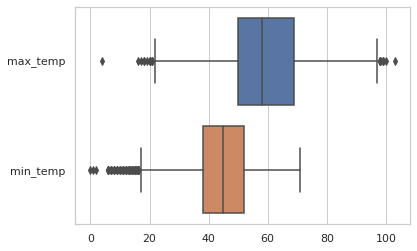

In [ ]:
sns.boxplot(data=condition[["max_temp", "min_temp"]], orient="h")

<AxesSubplot:xlabel='precipitation'>

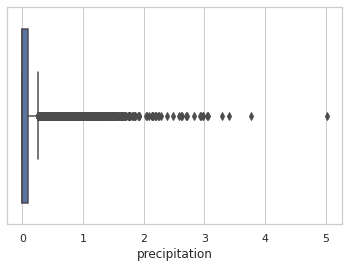

In [ ]:
sns.boxplot(x=condition['precipitation'])

## 2.) Removing Outliers

Outlier merupakan data-data yang sifatnya tidak biasa atau berbeda dari data atau kondisi yang umum terjadi. Kita ambil satu contoh pada kolom *precipitation* yang menunjukan nilai curah hujan tertingginya sebesar 5.02 inch. Apabila dilihat di boxplot, curah hujan sebesar itu sangat jarang terjadi sehingga bisa diklasifikasikan sebagai outlier.

Maka dari itu, outlier perlu dihapus supaya data-data yang digunakan pada proses selanjutnya memiliki keseragaman. Teknik yang digunakan untuk menghapus outlier adalah IQR (Inter Quartile Range).

In [ ]:
Q1 = condition.quantile(0.25)
Q3 = condition.quantile(0.75)
IQR = Q3-Q1

In [ ]:
print('Ukuran sebelum pembersihan outlier:', condition.shape)
condition = condition[~((condition<(Q1-1.5*IQR))|(condition>(Q3+1.5*IQR))).any(axis=1)].reset_index(drop=True)
print('Ukuran sesudah pembersihan outlier:', condition.shape)

Ukuran sebelum pembersihan outlier: (25548, 3)
Ukuran sesudah pembersihan outlier: (21890, 3)


# Data Visualization

In [ ]:
condition.describe()

,precipitation,max_temp,min_temp
count,21890.000000,21890.000000,21890.000000
mean,0.030577,60.775240,44.876245
std,0.059264,12.925476,8.938017
min,0.000000,24.000000,17.000000
25%,0.000000,51.000000,38.000000
50%,0.000000,60.000000,45.000000
75%,0.030000,70.000000,52.000000
max,0.250000,97.000000,69.000000


<AxesSubplot:>

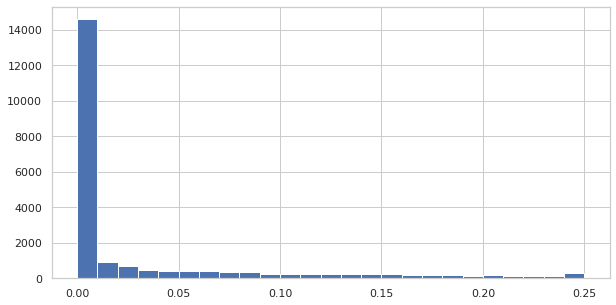

In [ ]:
condition['precipitation'].hist(bins=25, figsize=(10,5))

<AxesSubplot:>

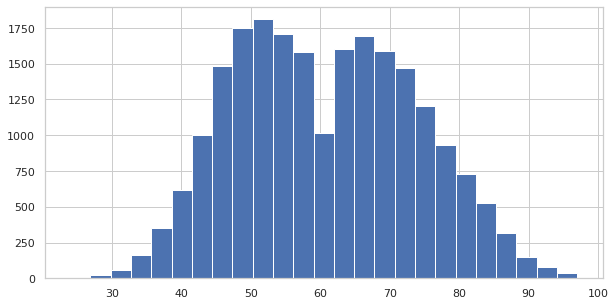

In [ ]:
condition['max_temp'].hist(bins=25, figsize=(10,5))

<AxesSubplot:>

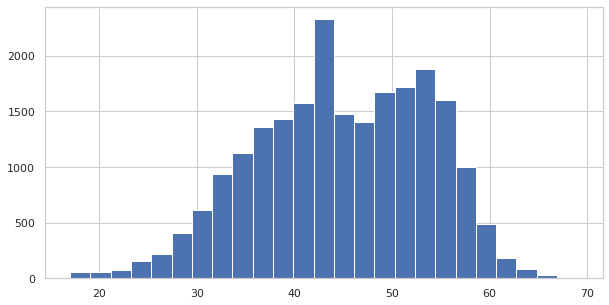

In [ ]:
condition['min_temp'].hist(bins=25, figsize=(10,5))

# Development

Tujuannya di sini adalah untuk mengetahui jenis-jenis kondisi hujan yang bisa diklasifikasikan oleh model. Untuk jumlah kategorinya bisa dideklarasikan dari awal atau juga bisa melalui percobaan.

Model memiliki kemampuan untuk mempelajari fitur-fitur yang tidak terlihat/tersembunyi pada data. Itulah alasan diperlukannya proses pembersihan outlier supaya data memiliki ciri dan karakteristik yang bisa dikenali.

## 1.) Standarizing Data

In [ ]:
scaler = StandardScaler()
condition_scaled = scaler.fit_transform(condition)
condition_scaled

array([[ 2.35263849, -1.22050434, -1.44064827],
       [ 0.15899789, -0.98839928, -1.10499569],
       [ 1.50893057, -0.83366257, -1.55253246],
       ...,
       [-0.51596844, -1.14313599, -1.44064827],
       [-0.51596844, -0.98839928, -1.21687988],
       [-0.51596844, -0.83366257, -0.99311149]])

## 2.) Model Building

In [ ]:
# Finding n Cluster
trial = []
for i in range(1, 11): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 321)
    kmeans.fit(condition_scaled) 
    trial.append(kmeans.inertia_)

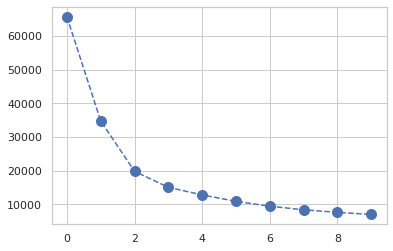

In [ ]:
plt.plot(trial, '--bo', markersize=10)
plt.show()

Setelah dilakukan pengujian menggunakan metode Elbow Curve barulah bisa dilihat bahwa kurva mulai melandai pada n ke 2, 3, 4 dan terlihat lurus pada n yang seterusnya. Maka dari itu, n yang akan dipakai pada tahap training adalah 4 supaya kategorinya bervariasi.

Faktanya, jumlah n bisa ditentukan dari awal dengan menentukan jumlah kelas yang ingin diinginkan tanpa perlu melalui tahap percobaan. Semua itu tergantung kebutuhan masing-masing individu.

### a.) K-Means

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=321)
kmeans.fit(condition_scaled)

KMeans(n_clusters=4, random_state=321)

### b.) Gaussian Mixture

In [ ]:
gmm = GaussianMixture(n_components=4, random_state=321)
gmm.fit(condition_scaled)

GaussianMixture(n_components=4, random_state=321)

# Model Evaluation

In [ ]:
condition.head()

,precipitation,max_temp,min_temp
0,0.17,45,32
1,0.04,48,35
2,0.12,50,31
3,0.01,42,32
4,0.00,41,26


In [ ]:
df_kmeans = condition.copy()
df_gmm = condition.copy()

## 1.) K-Means

In [ ]:
df_kmeans['category'] = kmeans.fit_predict(condition)
df_kmeans.head()

,precipitation,max_temp,min_temp,category
0,0.17,45,32,1
1,0.04,48,35,1
2,0.12,50,31,1
3,0.01,42,32,1
4,0.00,41,26,1


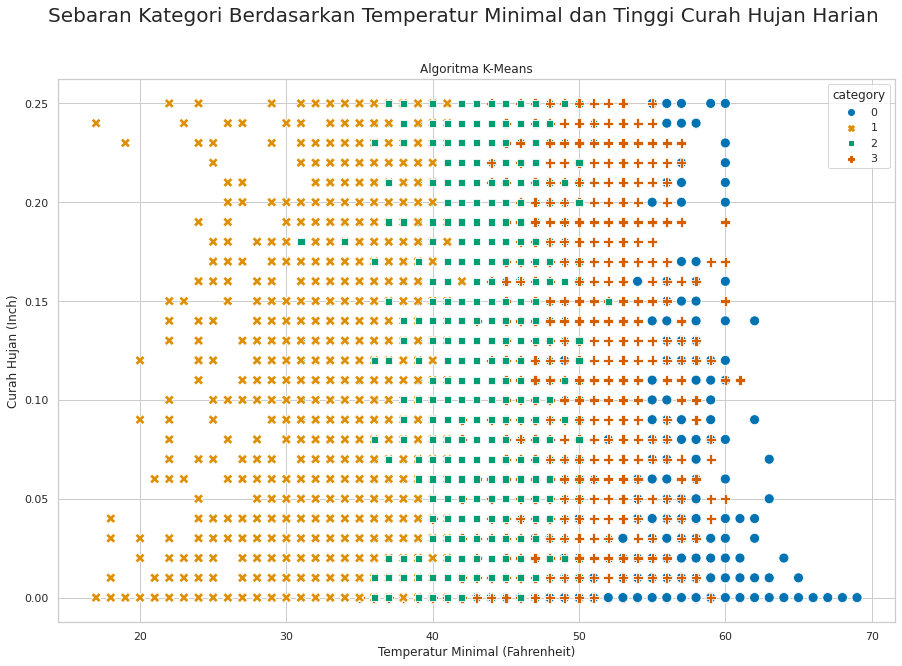

In [ ]:
plt.figure(figsize=[15,10])
sns.scatterplot(data = df_kmeans,
                x = "min_temp", 
                y = "precipitation", 
                hue = df_kmeans['category'], 
                style = df_kmeans['category'], 
                palette = "colorblind", 
                s=100)
plt.suptitle("Sebaran Kategori Berdasarkan Temperatur Minimal dan Tinggi Curah Hujan Harian", size=20)
plt.title("Algoritma K-Means", size=12)
plt.xlabel("Temperatur Minimal (Fahrenheit)")
plt.ylabel("Curah Hujan (Inch)")
plt.show()

Data terbagi menjadi 4 kelas, sesuai dengan jumlah n yang sudah ditentukan di tahap sebelumnya. Apabila dilihat dari grafik, kelas-kelas tersebut adalah Hujan pada Musim Semi (Jingga), Hujan pada Musim Panas (Biru), Hujan pada Musim Gugur (Hijau), dan Hujan pada Musim Dingin (Kuning). Karena algoritma k-means termasuk unsupervised learing maka label perlu dituliskan secara manual berdasar pengamatan yang dilakukan.

## 2.) Gaussean Mixture

In [ ]:
df_gmm['category'] = gmm.fit_predict(condition)
df_gmm.head()

,precipitation,max_temp,min_temp,category
0,0.17,45,32,2
1,0.04,48,35,1
2,0.12,50,31,2
3,0.01,42,32,1
4,0.00,41,26,0


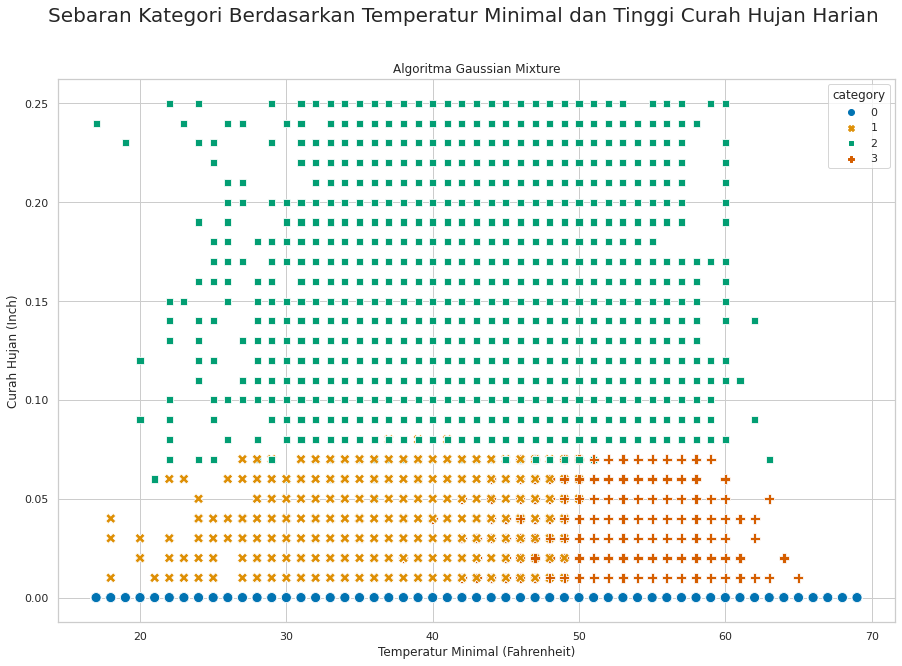

In [ ]:
plt.figure(figsize=[15,10])
sns.scatterplot(data = df_gmm, 
                x = "min_temp", 
                y = "precipitation", 
                hue = df_gmm['category'], 
                style = df_gmm['category'], 
                palette = "colorblind", 
                s=100)
plt.suptitle("Sebaran Kategori Berdasarkan Temperatur Minimal dan Tinggi Curah Hujan Harian", size=20)
plt.title("Algoritma Gaussian Mixture", size=12)
plt.xlabel("Temperatur Minimal (Fahrenheit)")
plt.ylabel("Curah Hujan (Inch)")
plt.show()

Data terbagi menjadi 4 kelas, sesuai dengan jumlah n yang sudah ditentukan di tahap sebelumnya. Apabila dilihat dari grafik, kelas-kelas tersebut adalah Tidak Hujan (Biru), Hujan Ringan (Jingga), Hujan Deras (Hijau), dan Hujan Salju (Kuning). Data berwarna kuning diberi label Hujan Salju karena hanya ditemui saat temperatur berada dibawah 50 derajat Fahrenheit (10 derajat Celsius). Perlu diingat bahwa data yang digunakan merupakan hasil observasi di Seattle yang dimana memiliki 4 musim. Karena algoritma gaussian mixture termasuk unsupervised learing maka label perlu dituliskan secara manual berdasar pengamatan yang dilakukan.

# Conclusion

K-Means memang merupakan salah satu metode terfavorit saat menyelesaikan masalah clustering. Tetapi hasil perhitungannya masih meleset dari yang diekspektasikan di awal. Sisi positifnya, model k-means berhasil menyajikan data yang 'tidak terlihat' yaitu mengklasifikasikan curah hujan berdasarkan musim.

Di sisi lain, algoritma Gaussian Mixture berhasil menyajikan data klasifikasi yang sesuai dengan ekspektasi. Sepertinya klasifikasi Hujan Deras (Hijau) bisa dibagi lagi menjadi Hujan Deras dan Badai Salju yang menjadikan jumlah n sama dengan 5. Hal tersebut bisa saja dilakukan seperti yang sudah dituliskan di awal bahwa nilai n bisa menyesuaikan kebutuhan penggunaan.

Tapi mau bagaimana lagi, namanya saja 'Unsupervised Learning' sudah jelas bahwa model akan membuat klasifikasi sesuai apa yang dipelajarinya, terkadang sulit untuk mendapatkan klasifikasi yang sesuai dengan keinginan manusia apalagi sampai 100% akurat berdasar data di lapangan. Sedikit tuning juga diperlukan untuk hasil yang memuaskan. Selain itu, banyak algoritma lainnya yang bisa digunakan untuk clustering yang bisa dicoba.